In [5]:
# run only if you have not installed the next libraries
"""
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install getdist
"""


'\n!pip install numpy\n!pip install matplotlib\n!pip install scipy\n!pip install getdist\n'

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as sci
import time
from getdist import plots, MCSamples
import time
#%matplotlib inline
%matplotlib notebook
dpi = 200

In [9]:
# Este programa implementa Hamiltonian Monte Carlo. El núcleo utilizado se basa en Metropolis Hastings.

class LeapFrog:
    def __init__(self, l, e, dw, m, z, dat, sigma):
        self.l = l
        self.e = e
        self.dw = dw
        self.m = m
        self.x = z
        self.y = dat
        self.sigma = sigma
        self.dim = len(self.m)
        
    def solve(self, theta):        
        qe = theta
        while True:
            pi = np.random.multivariate_normal(mean=np.zeros(self.dim), cov=np.diag(self.m))
            pe = pi
            self.H = []
            self.X = []
            self.P = []
            self.X.append(theta)
            self.P.append(pe)
            for i in range(self.l):
                pe = pe - 0.5*self.e*gradiente(self.dw, qe, self.x, self.y, self.sigma) # actualiza momento en e/2
                qe = qe + self.e*pe/self.m
                if qe[0]<0:
                    qe[0] = qe[0]*-1
                    pe[0] = pe[0]*-1
                if qe[1]<0:
                    qe[1] = qe[1]*-1
                    pe[1] = pe[1]*-1
                if qe[2]>1/3:
                    qe[2] = 1/3 - qe[2]
                    pe[2] = pe[2]*-1
                pe = pe - 0.5*self.e*gradiente(self.dw, qe, self.x, self.y, self.sigma)
                self.P.append(pe)
                self.X.append(qe)
                if i + 1==self.l: 
                    i += 1
                self.H.append(hamiltoniano(p=pe, dat=self.y, sigma=self.sigma, theta=theta, z=self.x, m=self.m))
            if i==self.l: 
                break
    
    
    def get(self):
        return np.array(self.X), np.array(self.P), np.array(self.H)

    
def likelihood(mod, dat, sigma): # retorna escalar, log(L)
    sig = np.diagonal(sigma)
    L = -0.5*chi2(mod, dat, sigma)[0]  + np.sum(-0.5*np.log(2*np.pi*sig**2))
    #pp = np.argwhere((a1==-np.inf))
    #a1[pp] = 0
    return L


def chi2(mod, dat, sigma):
    sig = np.diagonal(sigma)
    AA = np.sum(((dat - mod)/sig)**2)
    BB = np.sum((dat - mod)/sig**2)	
    CC = np.sum(1/sig**2)
    chi = AA - (BB**2)/CC
    return chi, BB/CC


def prior(theta): # log(pi)
    ct = 1
    r = np.diag(np.ones(len(theta))*ct)
    p = -0.5*np.log(np.linalg.det(2*np.pi*r)) - 0.5*theta.dot((np.linalg.inv(r)).dot(theta)) 
    return p


def acepta_hmc(ec, ep, EC, EP, x, X):
    alpha = min(- EP - EC + ep + ec, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return X, EP
    else:
        return x, ep
    
    
def acepta_mh(T1, pos1, T2, pos2, m1, m2):
    alpha = min(pos2 - pos1, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return T2, pos2, m2
    else:
        return T1, pos1, m1    


def EHubble(theta, z): # parametro de hubble
    om0 = theta[0]
    ol = theta[1]
    w = theta[2]
    arg = om0*(1 + z)**3 + (1 - om0 - ol)*(1 + z)**2 + ol*(1 + z)**(3*(1 + w))
    EE = np.sqrt(arg)
    return EE, arg


def modelo(theta, z): # modulo de la distancia teorico
    """
    theta: parameter space vector
    z: redshift
    """
    om0 = theta[0]
    ol = theta[1]
    omega_k = 1 - om0 - ol
    E = EHubble(theta, z)[0]
    I = sci.cumtrapz(1/(E + 1e-300), z, initial=0)+z[0]*((1/(E + 1e-300))[0] + 1)/2 # estabilidad numerica
    o_k_s = np.sqrt(abs(omega_k))
    if omega_k==0:
        dl = (1 + z)*I
    elif omega_k<0:
        dl = (1 + z)*np.sin(o_k_s*I)/(o_k_s + 1e-300) # estabilidad numerica
    elif omega_k>0:	
        dl = (1 + z)*np.sinh(o_k_s*I)/(o_k_s + 1e-300) # estabilidad numerica
    dist = 5*np.log10(dl + 1e-300) # estabilidad numerica
    #f (-np.inf==dist).any(): 
    #    print(theta)
    return dist


def tasa(tant, tpos):
    l = len(tant)
    if np.sum(tant==tpos)==l:
        c = 0
    else:
        c = 1
    return c


def revisa(theta, z):
    arg = EHubble(theta, z)[1]
    bol = np.sum(arg<0)
    print(bol)
    if bol>0:
        a = 0 # raiz imaginaria 
    else:
        a = 1 # raiz real
    return a


def argmin2(t1, t2, t3, V): # busca en base a vector chi2 y devulve minimos de los parametros
    amin = np.argmin(V)
    return t1[amin], t2[amin], t3[amin]


def revisa1(X):
    x = X[0]
    y = X[1]
    z = X[2]
    xlim = np.array([0, 1])
    ylim = xlim
    zlim = np.array([-np.inf, 1/3])
    if xlim[0]<x<xlim[1] and ylim[0]<y<ylim[1] and zlim[0]<z<zlim[1]:
        return 1
    else:
        return 0


def potencial(dat, sigma, theta, z):
    mod = modelo(theta, z)
    u = - likelihood(mod, dat, sigma) - prior(theta) 
    return u


def cinetica(p, m):
    k = np.sum(p**2/2/m)
    return k


def hamiltoniano(p, dat, sigma, theta, z, m=1):
    h = cinetica(p, m) + potencial(dat, sigma, theta, z)
    return h


def gradiente(dw, theta, z, dat, sigma):
    tf = theta + dw
    tb = theta - dw
    grad = (potencial(dat, sigma, tf, z) - potencial(dat, sigma, tb, z))/(2*dw)
    return grad


def HMC(modelo, datos, ds, dg, N, L, params, q0, cov_mod, m, des=0.24):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    acept = 0
    mod1 = modelo(q0, X)
    pos1 = potencial(Y, cov_mod, q0, X)
    Chi1 = chi2(mod1, Y, cov_mod)[0]
    chain.append(q0)
    post.append(pos1)
    chi_2.append(Chi1)
    Ratio.append(100)
    
    leap = LeapFrog(l=L, e=ds, dw=dg, m=m, z=X, dat=Y, sigma=cov_mod)

    Ti = time.time()
    for i in range(N):
        q = chain[i]
        while True:
            leap.solve(q)
            Q, P, H = leap.get()
            Q1 = Q[-1]
            P1 = P[-1]
            if revisa1(Q1):
                break
        t = cinetica(P1[0], m)
        u = potencial(Y, cov_mod, q, X)
        T = cinetica(P1, m)
        U = potencial(Y, cov_mod, Q1, X)
        A = acepta_hmc(t, u, T, U, q, Q1)
        chain.append(A[0])
        post.append(A[1])
        mod1 = modelo(A[0], X)
        Chi1 = chi2(mod1, Y, cov_mod)[0]
        chi_2.append(Chi1)
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%100==0:
            print(i)
            print('ratio', Ratio[i])

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')

    post = np.array(post)
    chain = np.array(chain)
    chi_2 = np.array(chi_2)
    Ratio = np.array(Ratio)
    H = np.array(H)

    t1 = chain[:,0]
    t2 = chain[:,1]
    t3 = chain[:,2]

    # busca argumento del minimo de chi2
    t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
    mins = [t1m, t2m, t3m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, chi_2, post, mins


def MH(modelo, datos, N, params, q0, cov_mod, cov_prop, des=0.24):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    #pid = PID(kp=10, ki=10, kd=10, o_min=2, o_max=20)
    T0 = q0
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    mod = []
    acept = 0
    mod0 = modelo(T0, X)
    chi0 = chi2(mod0, Y, cov_mod)[0]
    pos0 = likelihood(mod0, Y, cov_mod) + prior(T0)
    mod.append(mod0)
    chain.append(T0)
    post.append(pos0)
    chi_2.append(chi0)
    Ratio.append(100)

    # pasos de cadena
    Ti = time.time()
    for i in range(N):
        # revisa si se paso umbral de burn in
        """	
        if chi_2[i]<=580 and d==0 and o!=0:
            covarianza = COV[o]
            d = 1
            print('actualizada')
            print(covarianza)
        """	
        # selecciona ultimo elemento de la cadena
        T0 = chain[i]
        # itera hasta que encuentra un proposal valido
        while True:
            T1 = np.random.multivariate_normal(mean=T0, cov=cov_prop)
            if revisa1(T1):
                break
        # selecciona ultimo modelo
        mod0 = mod[i]
        # calcula modelo con proposal
        mod1 = modelo(T1, X)
        # selecciona ultima dis. post.
        pos0 = post[i]
        # calcula nueva dist. post.
        pos1 = likelihood(mod1, Y, cov_mod) + prior(T1)
        # decision de aceptacion
        A = acepta_mh(T0, pos0, T1, pos1, mod1, mod1)
        # guarda la variable aceptada (puede ser la anterior o proposal)
        chain.append(A[0])
        post.append(A[1])
        mod.append(A[2])
        chi_2.append(chi2(A[2], Y, cov)[0])
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%100==0:
            print(i)
            print('ratio', Ratio[i])

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')
    
    ratio = acept/N*100
    print('ratio %', np.rint(ratio))

    post = np.array(post)
    chain = np.array(chain)
    chi_2 = np.array(chi_2)
    Ratio = np.array(Ratio)
  
    t1 = chain[:,0]
    t2 = chain[:,1]
    t3 = chain[:,2]

    # busca argumento del minimo de chi2
    t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
    mins = [t1m, t2m, t3m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, chi_2, post, mins


def plot(arr1, arr2, keys, names, save=None):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
    ax1.scatter(arr1[0][keys[0]], arr1[0][keys[1]], marker='.', alpha=0.1)
    ax1.scatter(arr1[0][keys[0]][0], arr1[0][keys[1]][0], marker='x', color='red', alpha=1, label='inicio')
    ax1.scatter(arr1[4][0], arr1[4][1], marker='o', color='black', alpha=1, label='best fit')
    ax2.scatter(arr2[0][keys[0]], arr2[0][keys[1]], marker='.', alpha=0.1)
    ax2.scatter(arr2[0][keys[0]][0], arr2[0][keys[1]][0], marker='x', color='red', alpha=1, label='inicio')
    ax2.scatter(arr2[4][0], arr2[4][1], marker='o', color='black', alpha=1, label='best fit')
    ax1.set_title('HMC')
    ax2.set_title('MH')
    ax1.legend()
    ax2.legend()
    ax2.set_xlabel(names[0])
    ax2.set_ylabel(names[1])
    ax1.set_ylabel(names[1])
    if save!=None:
        fig.savefig('muestras_'+keys[0]+'_'+keys[1], dpi=dpi)
    return


def autocorrelation(x, kmax=None):
    N = len(x)
    xmean = np.mean(x)
    den = np.sum((x - xmean)*(x - xmean))    
    if kmax==None:
        kmax = int(N/2)
    C = []
    for i in range(kmax):
        if i==0:
            corr = 1
        else:
            corr = np.sum((x[i:] - xmean)*(x[:-i] - xmean))/den
        C.append(corr)
    return np.array(C)
    

In [16]:
# saved things directory
direc = "/home/claudia/Documents/Mau/Uni/primavera_2018/cosmo/gal.txt"
savepath = "/home/claudia/Documents/Mau/Uni/primavera_2018/cosmo/code"

# Carga de datos
redshift = np.genfromtxt(direc, usecols=(1))
mu_obs = np.genfromtxt(direc, usecols=(2)) # m - M
cov = np.genfromtxt(direc, usecols=(3))

p = np.argsort(redshift)
redshift = redshift[p]
mu_obs = mu_obs[p]
cov = cov[p]
cov = np.diag(cov)

In [17]:
low = [0., 0., -4.]
high = [1., 1., -1/3]
q0 = np.random.uniform(low=low, high=high)
mode = modelo(q0, redshift)
chi = chi2(mode, mu_obs, cov)
print(chi)

(588.9552467539907, 43.19828069458361)


In [18]:
# configuracion cadena

# params
labs = [r'$\Omega_{m}$', r'$\Omega_{\Lambda}$', r'w']
labs1 = [r'\Omega_{m}', r'\Omega_{\Lambda}', r'w']

M = -19.3182761161

# covarianza inicial
cov_ini = np.diag(np.array([0.4, 1.125, 4])**2)*0.5e-2
low = [0., 0., -6.]
high = [1., 1., 1/3]

nc = 40

## Metroplis-Hastings

In [19]:
# single chain

q0 = np.random.uniform(low=low, high=high) # np.array([0.5, 0.4, -2])
R_mh = MH(modelo, [redshift, mu_obs], N=10000, params=['om', 'ol', 'w'], q0=q0, cov_mod=cov, cov_prop=cov_ini)
chain = np.vstack((R_mh[0]['om'], R_mh[0]['ol'], R_mh[0]['w'])).T

np.save("{}/chain_points_mh".format(savepath), chain)

0
ratio 100
100
ratio 40.0
200
ratio 32.5
300
ratio 31.333333333333336
400
ratio 31.0
500
ratio 27.800000000000004
600
ratio 25.333333333333336
700
ratio 22.857142857142858
800
ratio 21.625
900
ratio 21.0
1000
ratio 20.599999999999998
1100
ratio 20.81818181818182
1200
ratio 20.0
1300
ratio 19.076923076923077
1400
ratio 19.071428571428573
1500
ratio 19.400000000000002
1600
ratio 19.8125
1700
ratio 20.294117647058822
1800
ratio 20.333333333333332
1900
ratio 20.05263157894737
2000
ratio 20.200000000000003
2100
ratio 20.19047619047619
2200
ratio 20.045454545454543
2300
ratio 19.956521739130434
2400
ratio 19.958333333333332
2500
ratio 20.52
2600
ratio 20.923076923076923
2700
ratio 21.14814814814815
2800
ratio 21.392857142857142
2900
ratio 21.310344827586206
3000
ratio 21.633333333333333
3100
ratio 21.516129032258064
3200
ratio 21.65625
3300
ratio 22.03030303030303
3400
ratio 22.176470588235293
3500
ratio 22.428571428571427
3600
ratio 22.25
3700
ratio 22.2972972972973
3800
ratio 22.447368421

In [10]:
# multiple chains

q0 = np.random.uniform(low=low, high=high) # np.array([0.5, 0.4, -2]) 
print('q0', q0)
Points = []
for i in range(nc):
    print('Chain {}'.format(i))
    q0 = np.random.uniform(low=low, high=high) # np.array([0.5, 0.4, -2])
    R_mh = MH(modelo, [redshift, mu_obs], N=10000, params=['om', 'ol', 'w'], q0=q0, cov_mod=cov, cov_prop=cov_ini)
    chain = np.vstack((R_mh[0]['om'], R_mh[0]['ol'], R_mh[0]['w'])).T
    Points.append(chain)
   
Points = np.array(Points)
Points = [Points[:, i, :] for i in range(Points.shape[1])]
Points = np.array(Points)

np.save("/home/mauricio/Documents/Uni/Intro_2/mh_results/chain_points_mh", Points)

q0 [ 0.74740231  0.32402542 -2.26941569]
Chain 0
0
ratio 100
100
ratio 33.0
200
ratio 36.0
300
ratio 33.0
400
ratio 28.499999999999996
500
ratio 25.6
600
ratio 25.0
700
ratio 23.857142857142858
800
ratio 22.875
900
ratio 23.333333333333332
1000
ratio 23.7
1100
ratio 23.727272727272727
1200
ratio 24.0
1300
ratio 24.076923076923077
1400
ratio 24.642857142857146
1500
ratio 25.133333333333336
1600
ratio 25.937500000000004
1700
ratio 26.11764705882353
1800
ratio 26.27777777777778
1900
ratio 26.36842105263158
2000
ratio 25.900000000000002
2100
ratio 25.571428571428573
2200
ratio 26.045454545454543
2300
ratio 25.91304347826087
2400
ratio 25.791666666666668
2500
ratio 25.759999999999998
2600
ratio 26.038461538461537
2700
ratio 26.074074074074073
2800
ratio 26.285714285714285
2900
ratio 26.482758620689655
3000
ratio 26.566666666666666
3100
ratio 26.70967741935484
3200
ratio 26.78125
3300
ratio 26.969696969696972
3400
ratio 26.705882352941174
3500
ratio 26.371428571428574
3600
ratio 26.472222222

9400
ratio 25.329787234042556
9500
ratio 25.31578947368421
9600
ratio 25.406250000000004
9700
ratio 25.402061855670105
9800
ratio 25.43877551020408
9900
ratio 25.474747474747474
Tiempo cadena 14.0 s
ratio % 26.0
Chain 3
0
ratio 100
100
ratio 36.0
200
ratio 31.5
300
ratio 30.666666666666664
400
ratio 30.0
500
ratio 30.4
600
ratio 30.5
700
ratio 30.714285714285715
800
ratio 30.375000000000004
900
ratio 30.11111111111111
1000
ratio 30.599999999999998
1100
ratio 30.636363636363633
1200
ratio 29.916666666666668
1300
ratio 29.846153846153843
1400
ratio 30.214285714285715
1500
ratio 30.266666666666666
1600
ratio 30.4375
1700
ratio 30.529411764705884
1800
ratio 30.166666666666668
1900
ratio 30.05263157894737
2000
ratio 29.799999999999997
2100
ratio 29.904761904761905
2200
ratio 29.909090909090907
2300
ratio 29.652173913043477
2400
ratio 29.416666666666668
2500
ratio 29.2
2600
ratio 29.384615384615387
2700
ratio 29.518518518518515
2800
ratio 29.57142857142857
2900
ratio 29.689655172413794
3000


8800
ratio 23.94318181818182
8900
ratio 23.95505617977528
9000
ratio 23.955555555555556
9100
ratio 23.98901098901099
9200
ratio 23.934782608695652
9300
ratio 23.956989247311828
9400
ratio 24.106382978723403
9500
ratio 24.042105263157897
9600
ratio 23.916666666666668
9700
ratio 23.989690721649485
9800
ratio 24.102040816326532
9900
ratio 24.252525252525253
Tiempo cadena 14.0 s
ratio % 24.0
Chain 6
0
ratio 100
100
ratio 30.0
200
ratio 31.5
300
ratio 31.333333333333336
400
ratio 32.25
500
ratio 30.8
600
ratio 29.833333333333336
700
ratio 29.57142857142857
800
ratio 29.25
900
ratio 30.0
1000
ratio 29.599999999999998
1100
ratio 30.545454545454547
1200
ratio 29.833333333333336
1300
ratio 29.230769230769234
1400
ratio 28.642857142857142
1500
ratio 27.866666666666667
1600
ratio 27.250000000000004
1700
ratio 26.41176470588235
1800
ratio 25.944444444444443
1900
ratio 25.263157894736842
2000
ratio 25.25
2100
ratio 24.952380952380953
2200
ratio 24.409090909090907
2300
ratio 24.26086956521739
2400
r

8600
ratio 23.837209302325583
8700
ratio 23.655172413793103
8800
ratio 23.69318181818182
8900
ratio 23.775280898876407
9000
ratio 23.733333333333334
9100
ratio 23.747252747252748
9200
ratio 23.73913043478261
9300
ratio 23.720430107526884
9400
ratio 23.69148936170213
9500
ratio 23.757894736842104
9600
ratio 23.71875
9700
ratio 23.79381443298969
9800
ratio 23.76530612244898
9900
ratio 23.747474747474747
Tiempo cadena 14.0 s
ratio % 24.0
Chain 9
0
ratio 100
100
ratio 35.0
200
ratio 29.5
300
ratio 31.666666666666664
400
ratio 29.75
500
ratio 29.2
600
ratio 28.999999999999996
700
ratio 27.0
800
ratio 25.25
900
ratio 25.333333333333336
1000
ratio 25.4
1100
ratio 24.363636363636363
1200
ratio 24.0
1300
ratio 24.076923076923077
1400
ratio 23.714285714285715
1500
ratio 23.666666666666668
1600
ratio 24.0
1700
ratio 24.47058823529412
1800
ratio 25.166666666666664
1900
ratio 25.31578947368421
2000
ratio 25.3
2100
ratio 24.904761904761905
2200
ratio 24.409090909090907
2300
ratio 24.130434782608695


8500
ratio 24.694117647058825
8600
ratio 24.61627906976744
8700
ratio 24.643678160919542
8800
ratio 24.693181818181817
8900
ratio 24.775280898876403
9000
ratio 24.688888888888886
9100
ratio 24.604395604395606
9200
ratio 24.586956521739133
9300
ratio 24.602150537634408
9400
ratio 24.659574468085108
9500
ratio 24.74736842105263
9600
ratio 24.78125
9700
ratio 24.690721649484537
9800
ratio 24.63265306122449
9900
ratio 24.585858585858585
Tiempo cadena 14.0 s
ratio % 24.0
Chain 12
0
ratio 100
100
ratio 28.000000000000004
200
ratio 21.5
300
ratio 21.333333333333336
400
ratio 20.75
500
ratio 22.2
600
ratio 23.833333333333336
700
ratio 24.285714285714285
800
ratio 24.75
900
ratio 25.77777777777778
1000
ratio 26.8
1100
ratio 26.81818181818182
1200
ratio 27.500000000000004
1300
ratio 26.923076923076923
1400
ratio 25.857142857142858
1500
ratio 25.666666666666664
1600
ratio 25.5625
1700
ratio 25.647058823529413
1800
ratio 25.833333333333336
1900
ratio 26.473684210526315
2000
ratio 26.70000000000000

8000
ratio 24.6125
8100
ratio 24.567901234567902
8200
ratio 24.597560975609756
8300
ratio 24.53012048192771
8400
ratio 24.357142857142858
8500
ratio 24.16470588235294
8600
ratio 24.058139534883722
8700
ratio 23.93103448275862
8800
ratio 24.0
8900
ratio 24.10112359550562
9000
ratio 24.122222222222224
9100
ratio 24.153846153846153
9200
ratio 24.22826086956522
9300
ratio 24.27956989247312
9400
ratio 24.393617021276594
9500
ratio 24.51578947368421
9600
ratio 24.614583333333336
9700
ratio 24.58762886597938
9800
ratio 24.5
9900
ratio 24.545454545454547
Tiempo cadena 15.0 s
ratio % 25.0
Chain 15
0
ratio 100
100
ratio 34.0
200
ratio 33.5
300
ratio 31.333333333333336
400
ratio 29.5
500
ratio 26.400000000000002
600
ratio 26.5
700
ratio 27.0
800
ratio 26.375
900
ratio 26.0
1000
ratio 24.8
1100
ratio 24.363636363636363
1200
ratio 23.833333333333336
1300
ratio 23.846153846153847
1400
ratio 23.857142857142858
1500
ratio 23.866666666666667
1600
ratio 24.4375
1700
ratio 23.941176470588236
1800
ratio 2

7500
ratio 26.0
7600
ratio 25.921052631578945
7700
ratio 25.948051948051948
7800
ratio 25.935897435897438
7900
ratio 26.075949367088608
8000
ratio 26.1625
8100
ratio 26.16049382716049
8200
ratio 26.231707317073173
8300
ratio 26.16867469879518
8400
ratio 26.107142857142858
8500
ratio 26.035294117647055
8600
ratio 25.86046511627907
8700
ratio 25.862068965517242
8800
ratio 25.96590909090909
8900
ratio 25.820224719101127
9000
ratio 25.822222222222223
9100
ratio 25.791208791208792
9200
ratio 25.66304347826087
9300
ratio 25.483870967741932
9400
ratio 25.372340425531913
9500
ratio 25.284210526315785
9600
ratio 25.239583333333332
9700
ratio 25.268041237113405
9800
ratio 25.265306122448976
9900
ratio 25.242424242424242
Tiempo cadena 14.0 s
ratio % 25.0
Chain 18
0
ratio 100
100
ratio 36.0
200
ratio 35.0
300
ratio 36.666666666666664
400
ratio 33.5
500
ratio 31.2
600
ratio 30.666666666666664
700
ratio 30.571428571428573
800
ratio 31.5
900
ratio 30.333333333333336
1000
ratio 28.9
1100
ratio 27.4545

7300
ratio 22.93150684931507
7400
ratio 22.83783783783784
7500
ratio 22.919999999999998
7600
ratio 23.013157894736842
7700
ratio 22.96103896103896
7800
ratio 22.897435897435898
7900
ratio 22.924050632911392
8000
ratio 23.1
8100
ratio 23.160493827160494
8200
ratio 23.085365853658537
8300
ratio 23.0
8400
ratio 23.107142857142858
8500
ratio 23.16470588235294
8600
ratio 23.30232558139535
8700
ratio 23.50574712643678
8800
ratio 23.65909090909091
8900
ratio 23.617977528089888
9000
ratio 23.799999999999997
9100
ratio 23.802197802197803
9200
ratio 23.82608695652174
9300
ratio 23.860215053763444
9400
ratio 23.829787234042556
9500
ratio 23.93684210526316
9600
ratio 23.927083333333332
9700
ratio 24.010309278350515
9800
ratio 24.0
9900
ratio 23.86868686868687
Tiempo cadena 14.0 s
ratio % 24.0
Chain 21
0
ratio 100
100
ratio 30.0
200
ratio 24.0
300
ratio 22.666666666666664
400
ratio 23.75
500
ratio 24.8
600
ratio 26.166666666666664
700
ratio 25.857142857142858
800
ratio 26.625
900
ratio 25.777777777

7500
ratio 24.04
7600
ratio 24.11842105263158
7700
ratio 24.194805194805195
7800
ratio 24.192307692307693
7900
ratio 24.30379746835443
8000
ratio 24.3125
8100
ratio 24.296296296296298
8200
ratio 24.402439024390244
8300
ratio 24.337349397590362
8400
ratio 24.38095238095238
8500
ratio 24.36470588235294
8600
ratio 24.406976744186046
8700
ratio 24.32183908045977
8800
ratio 24.238636363636363
8900
ratio 24.202247191011235
9000
ratio 24.288888888888888
9100
ratio 24.252747252747252
9200
ratio 24.16304347826087
9300
ratio 24.129032258064516
9400
ratio 24.170212765957448
9500
ratio 24.263157894736842
9600
ratio 24.34375
9700
ratio 24.288659793814432
9800
ratio 24.20408163265306
9900
ratio 24.08080808080808
Tiempo cadena 14.0 s
ratio % 24.0
Chain 24
0
ratio 100
100
ratio 43.0
200
ratio 32.0
300
ratio 30.333333333333336
400
ratio 28.499999999999996
500
ratio 28.199999999999996
600
ratio 27.833333333333332
700
ratio 27.42857142857143
800
ratio 27.125
900
ratio 27.22222222222222
1000
ratio 27.1
11

6900
ratio 25.869565217391305
7000
ratio 25.957142857142856
7100
ratio 25.943661971830984
7200
ratio 25.833333333333336
7300
ratio 25.753424657534246
7400
ratio 25.756756756756754
7500
ratio 25.866666666666667
7600
ratio 25.973684210526315
7700
ratio 25.935064935064933
7800
ratio 25.78205128205128
7900
ratio 25.797468354430382
8000
ratio 25.874999999999996
8100
ratio 26.0
8200
ratio 25.975609756097562
8300
ratio 26.072289156626503
8400
ratio 26.095238095238095
8500
ratio 25.96470588235294
8600
ratio 25.883720930232556
8700
ratio 25.862068965517242
8800
ratio 25.90909090909091
8900
ratio 25.988764044943817
9000
ratio 26.055555555555554
9100
ratio 26.10989010989011
9200
ratio 26.097826086956523
9300
ratio 26.161290322580644
9400
ratio 26.28723404255319
9500
ratio 26.14736842105263
9600
ratio 26.0
9700
ratio 26.051546391752577
9800
ratio 26.03061224489796
9900
ratio 26.01010101010101
Tiempo cadena 14.0 s
ratio % 26.0
Chain 27
0
ratio 100
100
ratio 32.0
200
ratio 30.5
300
ratio 30.33333333

6400
ratio 25.656250000000004
6500
ratio 25.70769230769231
6600
ratio 25.62121212121212
6700
ratio 25.582089552238806
6800
ratio 25.676470588235293
6900
ratio 25.7536231884058
7000
ratio 25.885714285714283
7100
ratio 25.873239436619716
7200
ratio 25.958333333333332
7300
ratio 25.972602739726025
7400
ratio 25.891891891891895
7500
ratio 25.96
7600
ratio 26.0
7700
ratio 25.870129870129873
7800
ratio 25.80769230769231
7900
ratio 25.63291139240506
8000
ratio 25.674999999999997
8100
ratio 25.691358024691358
8200
ratio 25.53658536585366
8300
ratio 25.481927710843372
8400
ratio 25.44047619047619
8500
ratio 25.41176470588235
8600
ratio 25.372093023255815
8700
ratio 25.39080459770115
8800
ratio 25.386363636363633
8900
ratio 25.48314606741573
9000
ratio 25.466666666666665
9100
ratio 25.560439560439562
9200
ratio 25.66304347826087
9300
ratio 25.79569892473118
9400
ratio 25.925531914893618
9500
ratio 26.0
9600
ratio 25.989583333333332
9700
ratio 25.969072164948454
9800
ratio 26.040816326530614
9900

6400
ratio 24.5625
6500
ratio 24.723076923076924
6600
ratio 24.666666666666668
6700
ratio 24.507462686567163
6800
ratio 24.39705882352941
6900
ratio 24.144927536231883
7000
ratio 24.12857142857143
7100
ratio 24.169014084507044
7200
ratio 24.055555555555554
7300
ratio 24.10958904109589
7400
ratio 24.0
7500
ratio 24.08
7600
ratio 24.11842105263158
7700
ratio 24.03896103896104
7800
ratio 24.153846153846153
7900
ratio 24.265822784810126
8000
ratio 24.1625
8100
ratio 24.061728395061728
8200
ratio 24.0
8300
ratio 24.012048192771086
8400
ratio 24.035714285714285
8500
ratio 24.188235294117646
8600
ratio 24.151162790697676
8700
ratio 24.195402298850574
8800
ratio 24.136363636363637
8900
ratio 24.224719101123597
9000
ratio 24.133333333333333
9100
ratio 24.087912087912088
9200
ratio 24.217391304347828
9300
ratio 24.236559139784948
9400
ratio 24.24468085106383
9500
ratio 24.38947368421053
9600
ratio 24.5
9700
ratio 24.525773195876287
9800
ratio 24.540816326530614
9900
ratio 24.505050505050505
Tiem

6200
ratio 24.241935483870968
6300
ratio 24.333333333333336
6400
ratio 24.390625
6500
ratio 24.569230769230767
6600
ratio 24.37878787878788
6700
ratio 24.46268656716418
6800
ratio 24.573529411764707
6900
ratio 24.695652173913043
7000
ratio 24.642857142857146
7100
ratio 24.746478873239436
7200
ratio 24.708333333333332
7300
ratio 24.73972602739726
7400
ratio 24.527027027027025
7500
ratio 24.44
7600
ratio 24.434210526315788
7700
ratio 24.441558441558442
7800
ratio 24.474358974358974
7900
ratio 24.39240506329114
8000
ratio 24.462500000000002
8100
ratio 24.530864197530864
8200
ratio 24.5
8300
ratio 24.518072289156624
8400
ratio 24.48809523809524
8500
ratio 24.494117647058825
8600
ratio 24.558139534883722
8700
ratio 24.57471264367816
8800
ratio 24.545454545454547
8900
ratio 24.48314606741573
9000
ratio 24.57777777777778
9100
ratio 24.58241758241758
9200
ratio 24.51086956521739
9300
ratio 24.41935483870968
9400
ratio 24.382978723404257
9500
ratio 24.431578947368422
9600
ratio 24.4895833333333

5700
ratio 24.701754385964914
5800
ratio 24.75862068965517
5900
ratio 24.71186440677966
6000
ratio 24.833333333333332
6100
ratio 24.852459016393443
6200
ratio 24.951612903225808
6300
ratio 24.88888888888889
6400
ratio 24.984375
6500
ratio 25.01538461538462
6600
ratio 24.863636363636363
6700
ratio 24.761194029850746
6800
ratio 24.66176470588235
6900
ratio 24.44927536231884
7000
ratio 24.37142857142857
7100
ratio 24.23943661971831
7200
ratio 24.319444444444443
7300
ratio 24.465753424657535
7400
ratio 24.594594594594597
7500
ratio 24.68
7600
ratio 24.63157894736842
7700
ratio 24.74025974025974
7800
ratio 24.679487179487182
7900
ratio 24.531645569620252
8000
ratio 24.6125
8100
ratio 24.62962962962963
8200
ratio 24.597560975609756
8300
ratio 24.69879518072289
8400
ratio 24.678571428571427
8500
ratio 24.658823529411762
8600
ratio 24.674418604651162
8700
ratio 24.57471264367816
8800
ratio 24.613636363636363
8900
ratio 24.696629213483146
9000
ratio 24.8
9100
ratio 24.857142857142858
9200
ratio

## Hamiltonian Monte Carlo
##### Select L between 5 and 10 steps

In [22]:
ds = 1e-2
m = np.array([1, 1, 1])
q0 = np.random.uniform(low=low, high=high) # np.array([0.5, 0.4, -2])
print('q0', q0)
Points = []
nc = 1
for i in range(nc):
    q0 = np.random.uniform(low=low, high=high) # np.array([0.5, 0.4, -2])
    print('Chain {}'.format(i))
    R_hmc = HMC(modelo, [redshift, mu_obs], ds=ds, dg=1e-6, N=5000, L=8, params=['om', 'ol', 'w'], 
            q0=q0, cov_mod=cov, m=m)
    chain = np.vstack((R_hmc[0]['om'], R_hmc[0]['ol'], R_hmc[0]['w'])).T
    Points.append(chain)
Points = np.array(Points)
Points = [Points[:, i, :] for i in range(Points.shape[1])]
Points = np.array(Points)

np.save("{}/chain_points_hmc".format(savepath), Points)


q0 [ 0.67939016  0.47076272 -1.66343602]
Chain 0
0
ratio 100
100
ratio 26.0
200
ratio 28.000000000000004
300
ratio 27.666666666666668
400
ratio 30.0
500
ratio 29.599999999999998
600
ratio 30.833333333333336
700
ratio 29.714285714285715
800
ratio 30.25
900
ratio 29.11111111111111
1000
ratio 27.3
1100
ratio 26.636363636363637
1200
ratio 26.0
1300
ratio 26.153846153846157
1400
ratio 26.42857142857143
1500
ratio 26.73333333333333
1600
ratio 27.187499999999996
1700
ratio 27.235294117647058
1800
ratio 28.666666666666668
1900
ratio 29.42105263157895
2000
ratio 29.849999999999998
2100
ratio 30.857142857142854
2200
ratio 31.727272727272727
2300
ratio 32.34782608695652
2400
ratio 32.79166666666667
2500
ratio 32.440000000000005
2600
ratio 32.57692307692307
2700
ratio 32.44444444444444
2800
ratio 32.32142857142858
2900
ratio 32.13793103448276
3000
ratio 32.03333333333334
3100
ratio 32.483870967741936
3200
ratio 33.0625
3300
ratio 32.87878787878788
3400
ratio 33.029411764705884
3500
ratio 33.428571

## Resultados

<IPython.core.display.Javascript object>


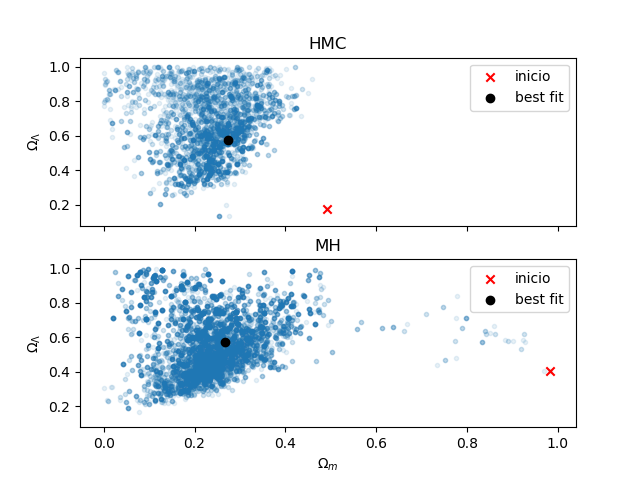

In [23]:
names = [r'$\Omega_{m}$', r'$\Omega_{\Lambda}$']
keys = ['om', 'ol']
plot(R_hmc, R_mh, keys, names, save='yes')

<IPython.core.display.Javascript object>


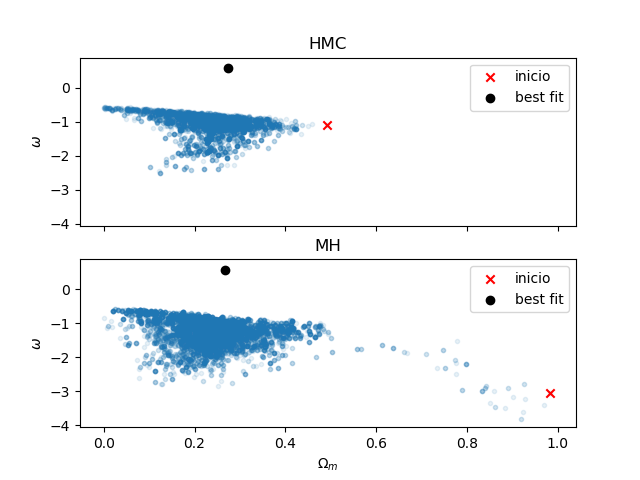

In [24]:
names = [r'$\Omega_{m}$', r'$\omega$']
keys = ['om', 'w']
plot(R_hmc, R_mh, keys, names, save='yes')

<IPython.core.display.Javascript object>


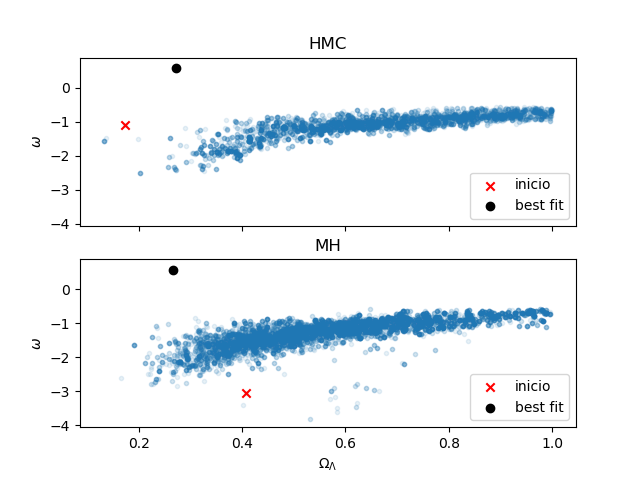

In [25]:
names = [r'$\Omega_{\Lambda}$', r'$\omega$']
keys = ['ol', 'w']
plot(R_hmc, R_mh, keys, names, save='yes please')

Removed no burn in


<IPython.core.display.Javascript object>


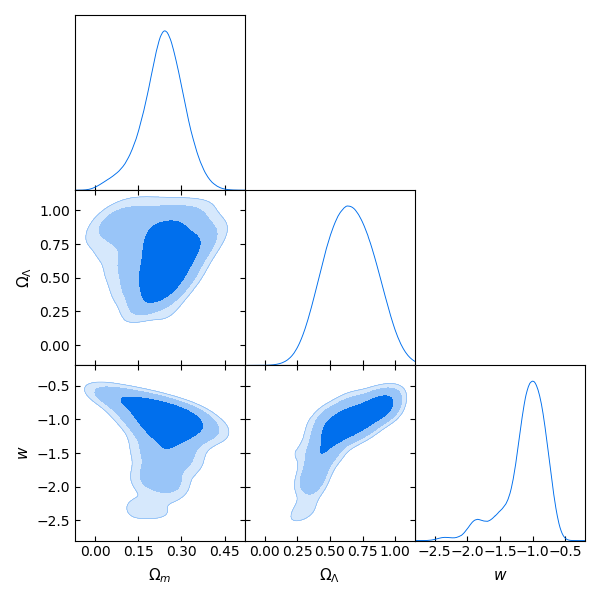

/home/claudia/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/home/claudia/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [37]:
ndim = 3
names = ["x%s"%i for i in range(ndim)]
labels = ["x_%s"%i for i in range(ndim)]
t1 = R_hmc[0]['om']
t2 = R_hmc[0]['ol']
t3 = R_hmc[0]['w']
samps = np.vstack((t1, t2, t3)).T
samples = MCSamples(samples=samps, names=labs1, labels=labs1)

#Triangle plot
g = plots.getSubplotPlotter()
samples.updateSettings({'contours': [0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 3
g.triangle_plot([samples], filled=True)


<IPython.core.display.Javascript object>


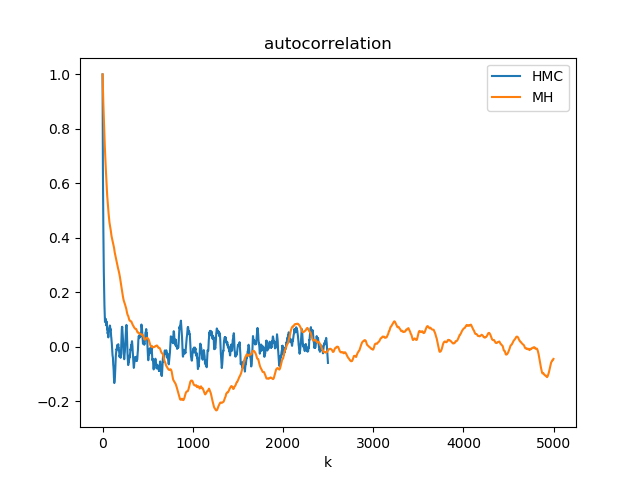

In [38]:
ac_hmc_om = autocorrelation(R_hmc[0]['om'])
ac_mh_om = autocorrelation(R_mh[0]['om'])

plt.clf()
plt.plot(ac_hmc_om, label='HMC')
plt.plot(ac_mh_om, label='MH')
plt.title('autocorrelation')
plt.legend()
plt.xlabel('k')
plt.show()